# Practical machine learning and deep learning. Lab 6

# Transfer Learning in Computer Vision

# [Competition](https://www.kaggle.com/t/17ac6cc24170468fb7bc3bf5bd9a5b23)

## Goal

In this lab you will implement clothes classifier using a pretrained model. You are allowed to use any pretrained model that you know (e.g. VGG, ResNet, etc.)

## Submission

Submission format is described at competition page.

> Remember, you can use any structure of the solution. The template classes/function in this file is just the tip for you.

In [ ]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

torch.manual_seed(0)

## Data reading and preprocessing

Prepare a class for FashionMNIST dataset to easily read data and apply transformations when retrieving examples.

In [ ]:
from torch.utils.data import Dataset
import torchvision.transforms as transforms

class FashionMNISTDataset(Dataset):
    '''Dataset class for FashionMNIST'''

    def __init__(self, csv_path, train=True):
        ''' Read data and prepare tranforms

            Args:
            - csv_path(str): full name of the csv file
            - train(bool): is train set loaded, determines whether to return labels
        '''
        self.csv_path = csv_path
        self.train = train

        self.transform = transforms.Compose([
            # Make tensors
            ...
            # Question: Do we always need to resize the images to the input
            # shape of the pretrained model? Resize them if required
            ...
        ])

        # Read csv file of the dataset and set index_col to 0
        self.fm_raw = pd.read_csv(csv_path, index_col=0)

        if train:
            # Extract the pixel values of the images as a numpy array
            self.images = ...
            # Reshape images to have 28x28 shape
            self.images = ...
            # Make pixels vary from 0 to 1
            self.images = ...
            # The last column of the dataframe stores that labels. Extract them.
            self.labels = ...
        else:
            # Extract the pixel values of the images as a numpy array
            self.images = ...
            # Reshape images to have 28x28 shape
            self.images = ...
            # Make pixels vary from 0 to 1
            self.images = ...
            # There is no labels in the test dataset, so they are set to None
            self.labels = None

    def __getitem__(self, index):
        '''Returns the data of the example at the given index'''
        if self.train:
            # Get images at the given index
            images = ...
            # Transform the images
            transformed_images = ...
            # Get labels at the given index
            labels = ...
            # Return transformed_images and labels as a pair
            return transformed_images, labels
        else:
            # Get images at the given index
            images = ...
            # Transform the images
            transformed_images = ...
            # Return only transformed images since it is a testing subset
            return transformed_images

    def __len__(self):
        '''Returns length of the dataset'''
        return len(self.images)

Read data and prepare a dataset

In [ ]:
import os

dir = '/kaggle/input/pmldl-week6-transfer-learning-in-cv/'
filename = 'fashion_mnist_train.csv'
full_filename = os.path.join(dir, filename)

dataset = FashionMNISTDataset(csv_path=full_filename, train=True)

Split the dataset into training and validation subsets using `random_split`

In [ ]:
from torch.utils.data import random_split

# Set percentage of data to use as a training subset
train_ratio = ...

train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(...)

Make dataloader to perform batching and apply transformations

In [ ]:
from torch.utils.data import DataLoader

# Set the batch size
batch_size = ...

train_loader = DataLoader(...)
val_loader = DataLoader(...)

Visually check the images

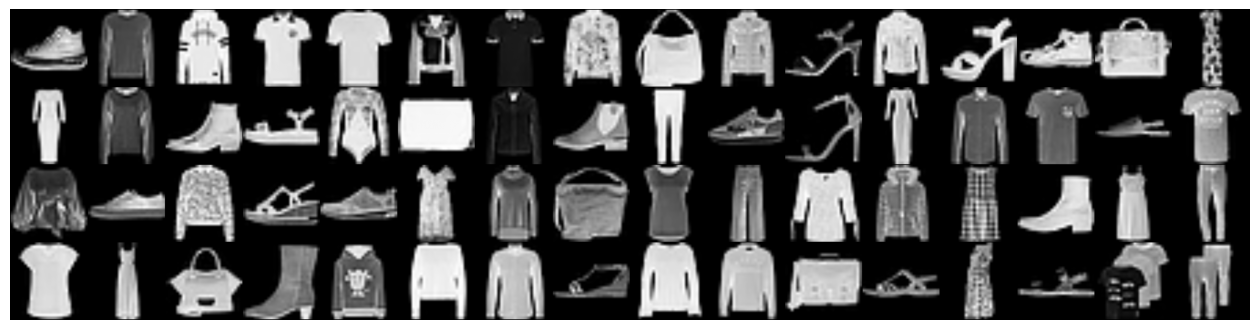

In [ ]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

for images, _ in train_loader:
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

## Model Implementation
Implement a PyTorch model that uses a pretrained model for computer vision to classify the clothes. You are allowed to use any models initially trained for other tasks (e.g. VGG, ResNet, etc). You may experiment with [freezing](https://pytorch.org/docs/master/notes/autograd.html#setting-requires-grad) some layers of the pretrained model. If you are interested, you may try to build your own CNN model for FashionMNIST classification.

In [ ]:
import torchvision.models as models
import torch.nn as nn

class FashionMNISTModel(nn.Module):
  '''PyTorch model for FashionMNIST classification'''

  def __init__(self, in_channels=1):
    '''Sets the pretrained model and makes specific modifications'''
    super(FashionMNISTModel, self).__init__()

    # Here you load a pretrained model and
    # add modifications to classify FashionMNIST images
    # out of 10 possible labels
    ...
    ...
    ...

  def forward(self, x):
    '''Determines the sequence of actions to classify images x'''
    return ...

In [ ]:
# Select the where to perform calculations
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# Create an instance of the model and pass its weights to the device
model = FashionMNISTModel().to(device)
# Set the loss function
loss_function = ...
# Set the opimizer
optimizer = ...

## Model Training

Fine-tuning of the pretrained model on our specific task of clothes classification.

Here are utility functions to calculate and show metrics:

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def calculate_metric(metric_fn, true_y, pred_y):
    if metric_fn != accuracy_score:
        return metric_fn(true_y, pred_y, average="macro")
    else:
        return metric_fn(true_y, pred_y)

def print_scores(p, r, f1, a, batch_size):
    for name, scores in zip(("precision", "recall", "F1", "accuracy"), (p, r, f1, a)):
        print(f"\t{name.rjust(14, ' ')}: {sum(scores)/batch_size:.4f}")

Training loop

In [ ]:
from tqdm import tqdm

epochs = ...

losses = []
batches = len(train_loader)
val_batches = len(val_loader)

# loop for every epoch (training + evaluation)
for epoch in range(epochs):
    total_loss = 0

    # progress bar
    progress = tqdm(enumerate(train_loader), desc="Loss: ", total=batches)

    # ----------------- TRAINING  --------------------
    # set model to training
    model.train()

    for i, data in progress:
        images, labels = ...

        # training step for single batch
        ...

        # update running training loss
        current_loss = loss.item()
        total_loss += current_loss * images.size(0)

        # updating progress bar
        progress.set_description("Loss: {:.4f}".format(total_loss/(i+1)))

    # releasing unceseccary memory in GPU
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    # ----------------- VALIDATION  -----------------
    val_losses = 0
    precision, recall, f1, accuracy = [], [], [], []

    # set model to evaluating (testing)
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            images, labels = ...

            outputs = ...

            # update running validation loss
            val_losses += loss_function(outputs, labels) * images.size(0)

            predicted_classes = ...

            # calculate P/R/F1/A metrics for batch
            for acc, metric in zip((precision, recall, f1, accuracy),
                                   (precision_score, recall_score, f1_score, accuracy_score)):
                acc.append(
                    calculate_metric(metric, labels.cpu(), predicted_classes.cpu())
                )

    print(f"Epoch {epoch+1}/{epochs}, training loss: {total_loss/batches}, validation loss: {val_losses/val_batches}")
    print_scores(precision, recall, f1, accuracy, val_batches)
    losses.append(total_loss/batches)

## Inference
Produce labels on the testing images

Load the dataset in the testing mode

In [ ]:
import os

dir = '/kaggle/input/pmldl-week6-transfer-learning-in-cv/'
filename = 'fashion_mnist_test_data.csv'
full_filename = os.path.join(dir, filename)

test_dataset = FashionMNISTDataset(csv_path=full_filename, train=False)

Make a loader of the testing dataset

In [ ]:
test_loader = DataLoader(...)

Make predictions and generate a submission file

In [ ]:
predictions = []

with torch.no_grad():
    model.eval()
    for i, images in enumerate(test_loader):
        ...

In [ ]:
# generate the submission file
submission_df = pd.DataFrame(columns=['id', 'label'])
submission_df['id'] = test_dataset.fm_raw.index
submission_df['label'] = predictions
submission_df.to_csv('submission.csv', index=None)